## Main code to analyse preservation trends in bar packages. 
Inputs = CSVs with bar stats, and various input arrays for package statistics

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from matplotlib import cm
from pylab import *
import matplotlib.colors as mcol
from matplotlib.colors import LinearSegmentedColormap


import os
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.stats as stats

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
## Set Color maps for plots and plot aesthetics

coher_cols = ['#276419', '#9ccf64', '#f7f7f7', '#e896c4', '#8e0152'] ##PiYG 5 steps
coher_cols_seq = ['#d8ffff', '#85d9f0', '#2cb0e0', '#0083c6', '#0057a7'] #light blue to blue
# pres_cols = ['xkcd:pink', 'xkcd:lavender', 'xkcd:light grey'] #pink = FP, lav = PP, blue = TR
pres_cols = ['xkcd:primary blue', 'xkcd:soft blue', 'xkcd:pink red']
pres_cols = ['#e08266', '#feb9a8', '#8da0ae']##for SANCAS and AGU
proc_cols = ['#ff8500', '#ffca20', '#ffffe0', '#bf74e7', '#8044da'] #(orange to purple) agg to lat acc
pres_palette = sns.color_palette(pres_cols)
coh_palette = sns.color_palette(coher_cols_seq)
proc_palette = sns.color_palette(proc_cols)

font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 8}

mpl.rc('font', **font)

Import files

In [5]:
## import datamaster for comparative statistics
idf = '0hfld' #identifier/classifier about the flood setting
intstring = '2hour' #time interval of output
nickname = 'agubh2-10km' #model nickname, agubh2, gentle_wide etc
floodname ='_0hrflood'
adjustment_time = 65
meanTT = 13

datnam = f'{idf}-datamaster-{intstring}-ud.npy' #name of the data file to upload
dataloc = f'data-{nickname}{floodname}' #where csv files are
paper_fig_path = '/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/'
datamaster = np.load(f'/Volumes/SAF_Data/NAYS2DH_files/Data/ConvertedArrays/{dataloc}/{datnam}', allow_pickle = True)

In [6]:
perc_untouched = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_percent_untouched.npy') ## channel profile for each timestep

In [7]:
savefilesto = '/Volumes/SAF_Data/bar-manuscript_sum22/data-interp/'
eqt = 65 ## time for the bed to equilibrate

## import all additional datasets
## array of number of active channels
active_channels = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2_active_channels-ud.npy') 

## array of wetted width
wetted_width = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2WWmaster-ud.npy') 
wetted_width[:adjustment_time, :] = np.nan 


In [8]:
mypath = '/Volumes/SAF_Data/NAYS2DH_files/Data/BarCSVs/concat-files/agubh2-250mint-p1p2.csv'
allbars = pd.read_csv(mypath, sep = ',', header = 0)

Text(0.5, 1.0, 'Proportion of Fully, Partially Preserved and Truncated bars in the model run \n Bar area (top) and bar count (bottom)')

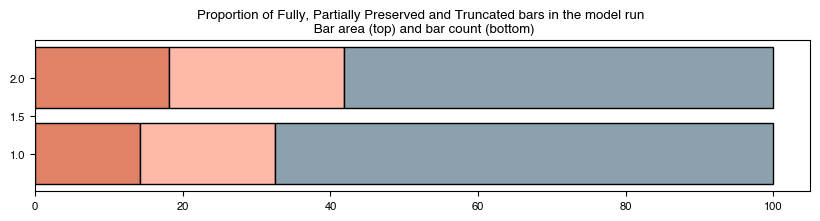

In [9]:
plt.figure(figsize = (10, 2), dpi = 100)
percfp = len(allbars[allbars['PreservChar']=='FP'])*100/len(allbars)
percpp = len(allbars[allbars['PreservChar']=='PP'])*100/len(allbars)
perctr = len(allbars[allbars['PreservChar']=='TR'])*100/len(allbars)
plt.barh(1,  percfp, color = pres_palette[0], edgecolor = 'k')
plt.barh(1,  percpp, left = percfp, color = pres_palette[1], edgecolor = 'k')
plt.barh(1,  perctr, left = percfp+percpp, color = pres_palette[2], edgecolor = 'k')


areafp = np.sum(allbars['BarArea'][allbars['PreservChar']=='FP'])*100/np.sum(allbars['BarArea'])
areapp = np.sum(allbars['BarArea'][allbars['PreservChar']=='PP'])*100/np.sum(allbars['BarArea'])
areatr = np.sum(allbars['BarArea'][allbars['PreservChar']=='TR'])*100/np.sum(allbars['BarArea'])
plt.barh(2, areafp, color = pres_palette[0], edgecolor = 'k')
plt.barh(2, areapp, left = areafp, color = pres_palette[1], edgecolor = 'k')
plt.barh(2, areatr, left = areafp+areapp, color = pres_palette[2], edgecolor = 'k')

plt.title('Proportion of Fully, Partially Preserved and Truncated bars in the model run \n Bar area (top) and bar count (bottom)')
# plt.yticks([])

# plt.savefig(f'{paper_fig_path}pro-bars.png', dpi = 200, transparent = True)

In [10]:
print(areatr, areapp, areafp)
areatr+areapp+areafp

58.15767132165576 23.667942451926542 18.17438622641769


100.0

In [11]:
## import widening rates
#profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh210km-profile.npy') ## channel profile for each timestep
profile_master = np.load('/Volumes/SAF_Data/NAYS2DH_files/Data/nparrays/agubh2-channel-profile.npy') ## channel profile for each timestep

# profile_master[:eqt, :, :] = np.nan
profile_master = profile_master[:, :, adjustment_time:]
print(profile_master.shape)


## the first row is all nans i dont know why just leave it out everything else is fine
# 0 = ilocs, starts at 0m, every 10m
# 1 = right bank
# 2 = left bank
# 3 = rb displacement (from timestep before)
# 4 = lb displacement (from timestep before)
# 5 = rb widening rate------NAN!!!
# 6 = lb widening rate (2 hr intervals)-----NAN!!!
interval = 2
cropint = 5
tt_crop = deepcopy(profile_master[:, :, ::meanTT]) ##widening rate at median turnover timescalae (13 pyts)
widening_tt = ((tt_crop[:, 2, 1:]-tt_crop[:, 1, 1:])-(tt_crop[:, 2, :-1]-tt_crop[:, 1, :-1]))/(interval*meanTT) ##every 10 hours

pm_10 = deepcopy(profile_master[:, :, ::cropint]) ## profile data every 10 cropint timesteps (here 10 model hrs)
total_wr = ((pm_10[:, 2, 1:]-pm_10[:, 1, 1:])-(pm_10[:, 2, :-1]-pm_10[:, 1, :-1]))/(interval*cropint) ##every 10 hours

total_wr_2h = ((profile_master[:, 2, 1:]-profile_master[:, 1, 1:])-(profile_master[:, 2, :-1]-profile_master[:, 1, :-1]))/interval

(1001, 7, 317)


## Box plots by preservation

In [12]:
allbars = allbars.drop([523])

In [13]:
allbars.columns

Index(['Unnamed: 0', 'BarName', 'array name', 'iloc', 'PreservChar',
       'CoherenceVal', 'StartTime', 'EndTime', 'ElapsedTime', 'LeftEdge',
       'RightEdge', 'BarWidth', 'BarHeight', 'BarAspect', 'BarArea',
       'Section Area', 'ChannelProp', 'Angle Skewness', 'Basal Surf Relief',
       'Mean dzdx', 'Median dzdx', 'MinClinoHt', 'MaxClinoHt', 'ModeClinoHt',
       'MeanClinoHt', 'SDClinoHt', 'MedClinoHt', 'MinClinoWt', 'MaxClinoWt',
       'ModeClinoWt', 'MeanClinoWt', 'SDClinoWt', 'MedClinoWt', 'MinClinoICD',
       'MaxClinoICD', 'ModeClinoICD', 'MeanClinoICD', 'SDClinoICD',
       'MedClinoICD', 'MinFlowDepth', 'MaxFlowDepth', 'ModeFlowDepth',
       'MeanFlowDepth', 'SDFlowDepth', 'MedFlowDepth', 'MinShear', 'MaxShear',
       'ModeShear', 'MeanShear', 'SDShear', 'MedShear', 'MinVelocity',
       'MaxVelocity', 'ModeVelocity', 'MeanVelocity', 'SDVelocity',
       'MedVelocity', 'TRAINFLAG', 'notes', 'CVFlowDepth', 'CVVelocity',
       'VarFlowDepth', 'VarVelocity', 'Skew Abs

# Final plots for manuscript

### Boxplots

In [14]:
### Varaibles to plot

geometric_vars = ['BarArea', 'BarWidth', 'BarHeight']#
# facies = ['prop ub', 'prop lb']
scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxClino/MedFD', 'PkgHeight/MedFD']
time = ['MeanAge', 'ElapsedTime', 'GrowthR8']

xs_props = ['ChannelProp', 'BL/CL', 'BarAspect']
clino_geom = ['MeanClinoHt', 'MaxClinoHt', 'MeanClinoWt']
facies = ['MeanShear', 'MeanVelocity', 'UBar']


### Boxplot properties
flierprops = dict(marker='o', markerfacecolor='xkcd:gray', markersize=2,  markeredgecolor='xkcd:gray')
meanprops = dict(marker = 'o', markerfacecolor = 'blue', ms = 0, mec = 'k', mew = 0, linestyle = '--', linewidth = 1.5, color = 'k')
meanlineprops = dict(linestyle = '-', lc = 'k', lw = 2)
boxprops = dict(edgecolor = 'k', linewidth = 1.5)
capprops = dict(color = 'k', linewidth = 1.5)
whiskerprops = dict(color = 'k')
boxwidth = 0.35
linewidth = 1.5

### for supplement

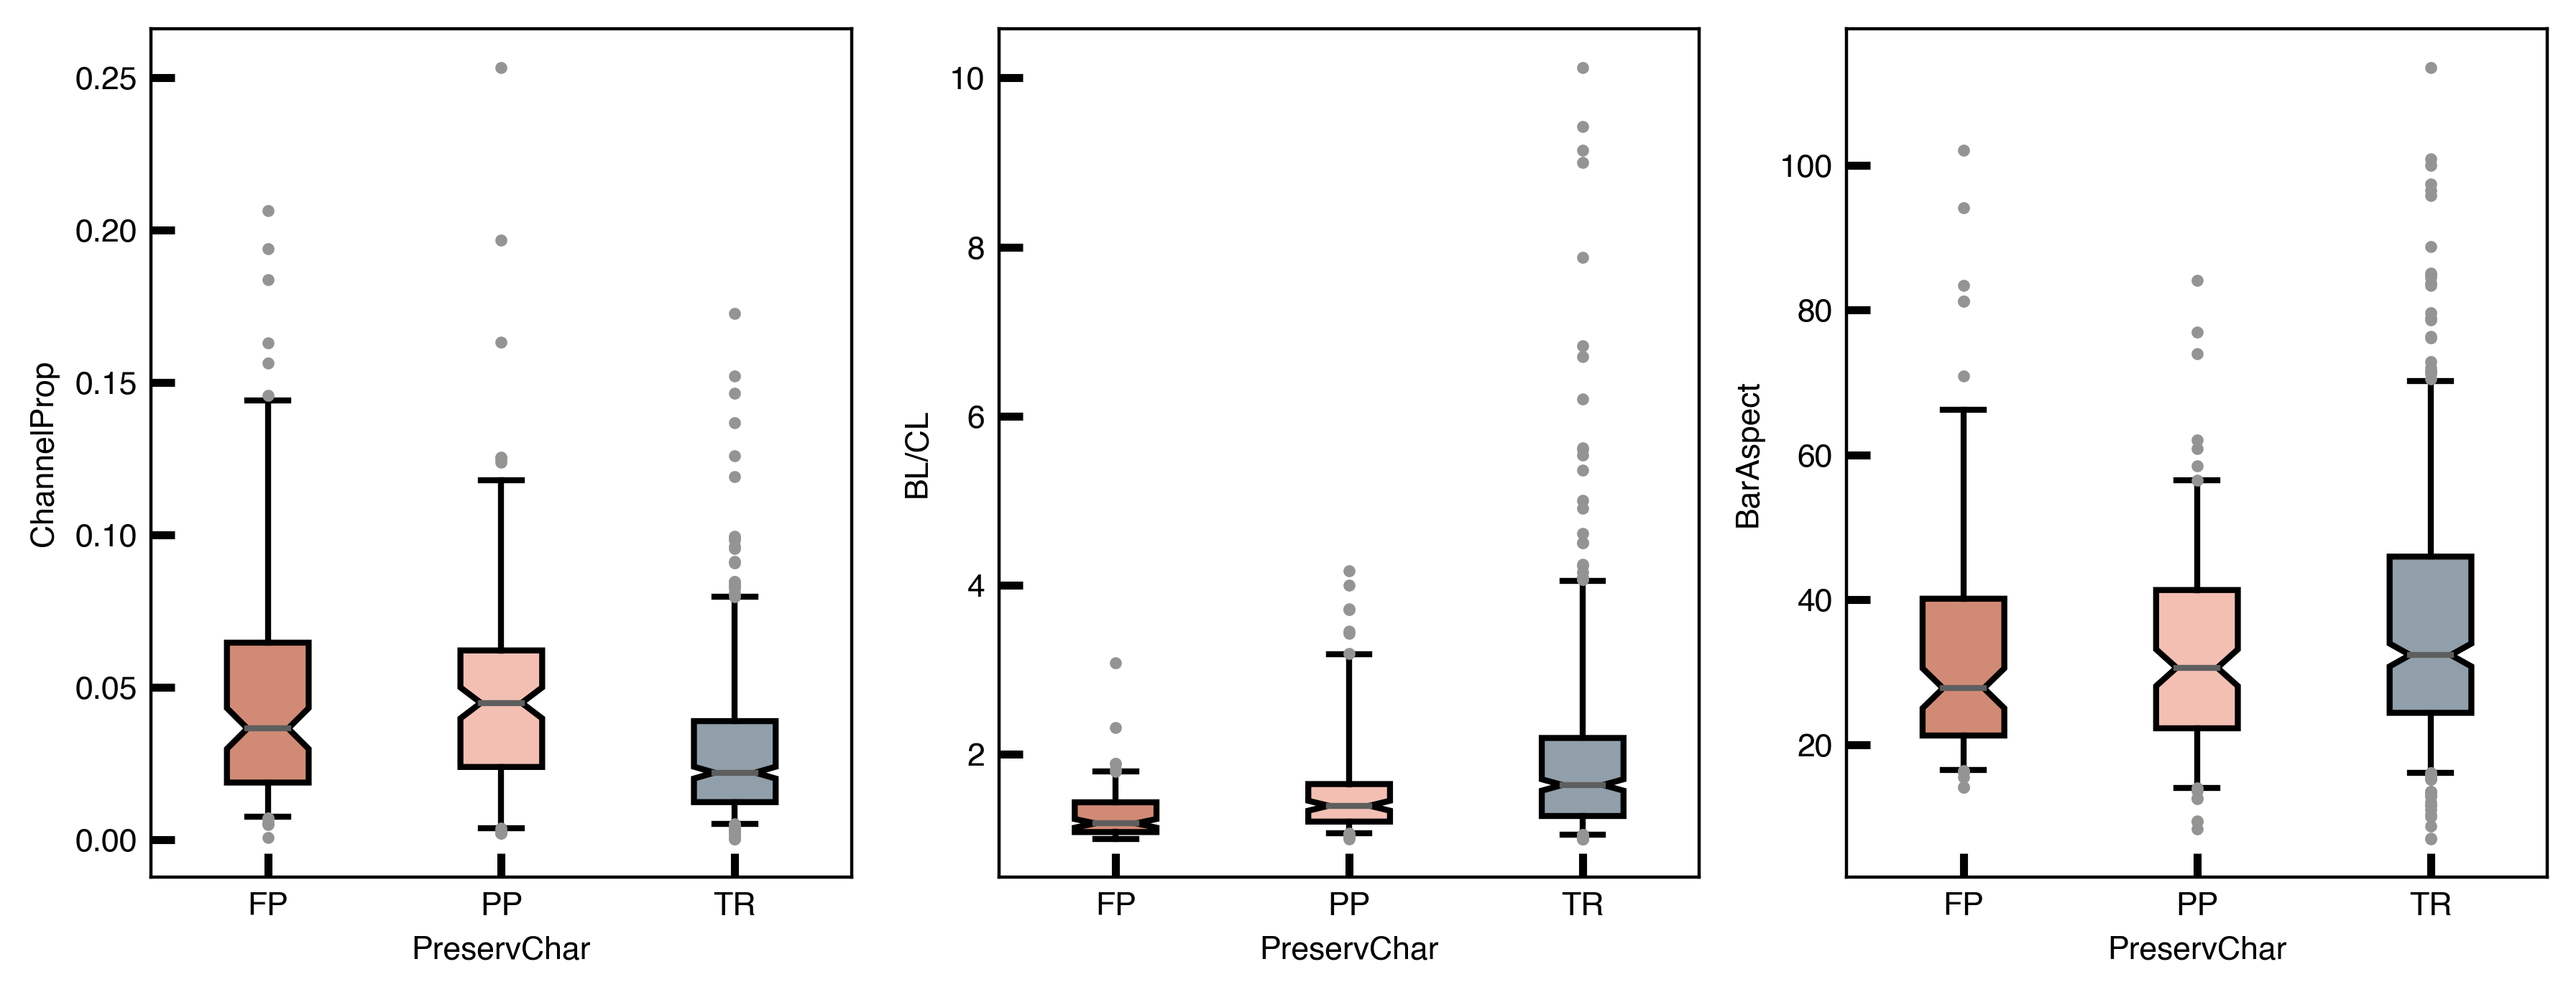

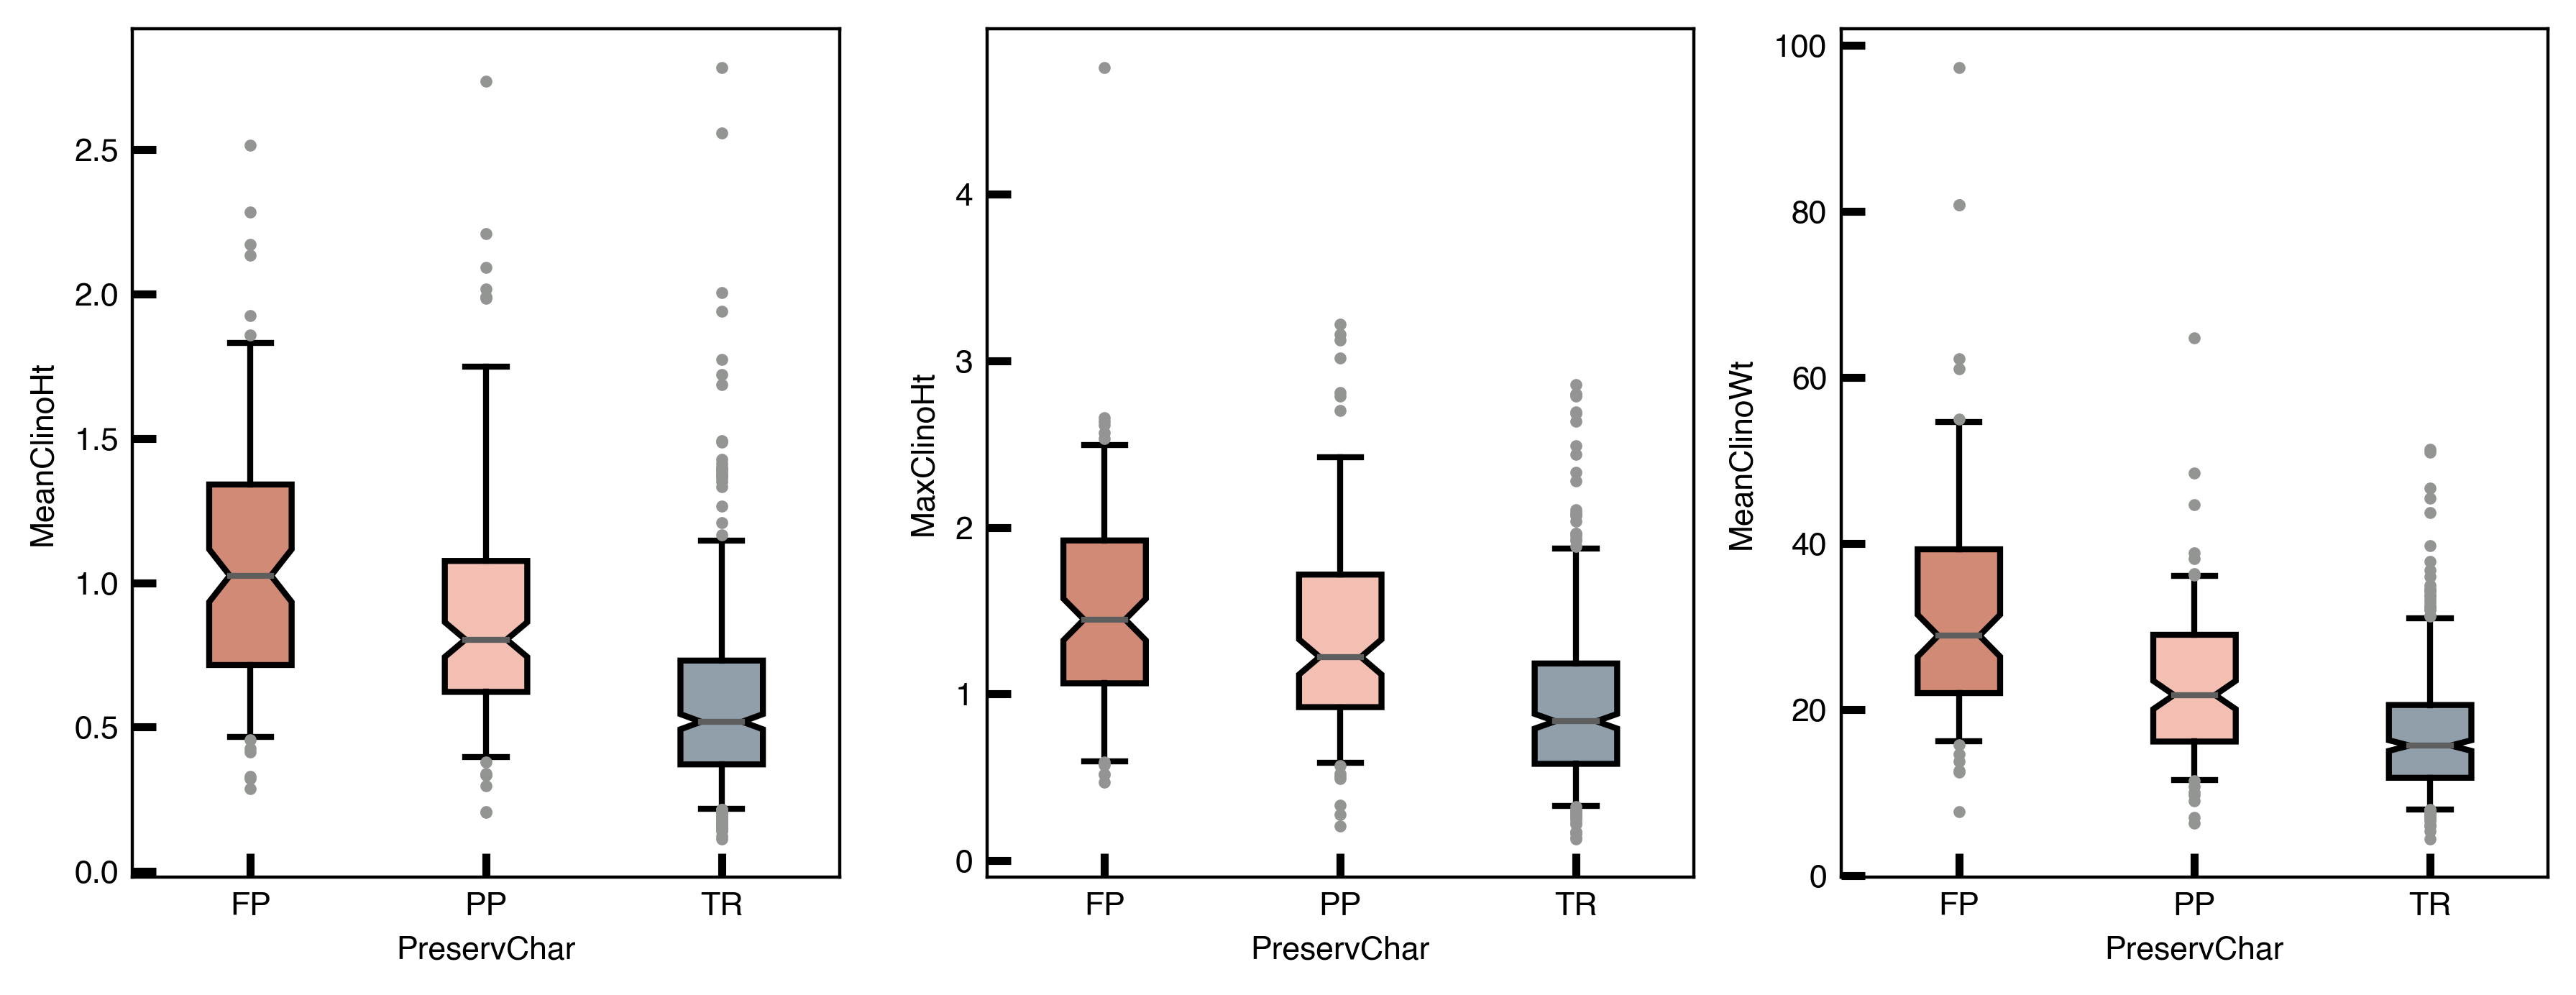

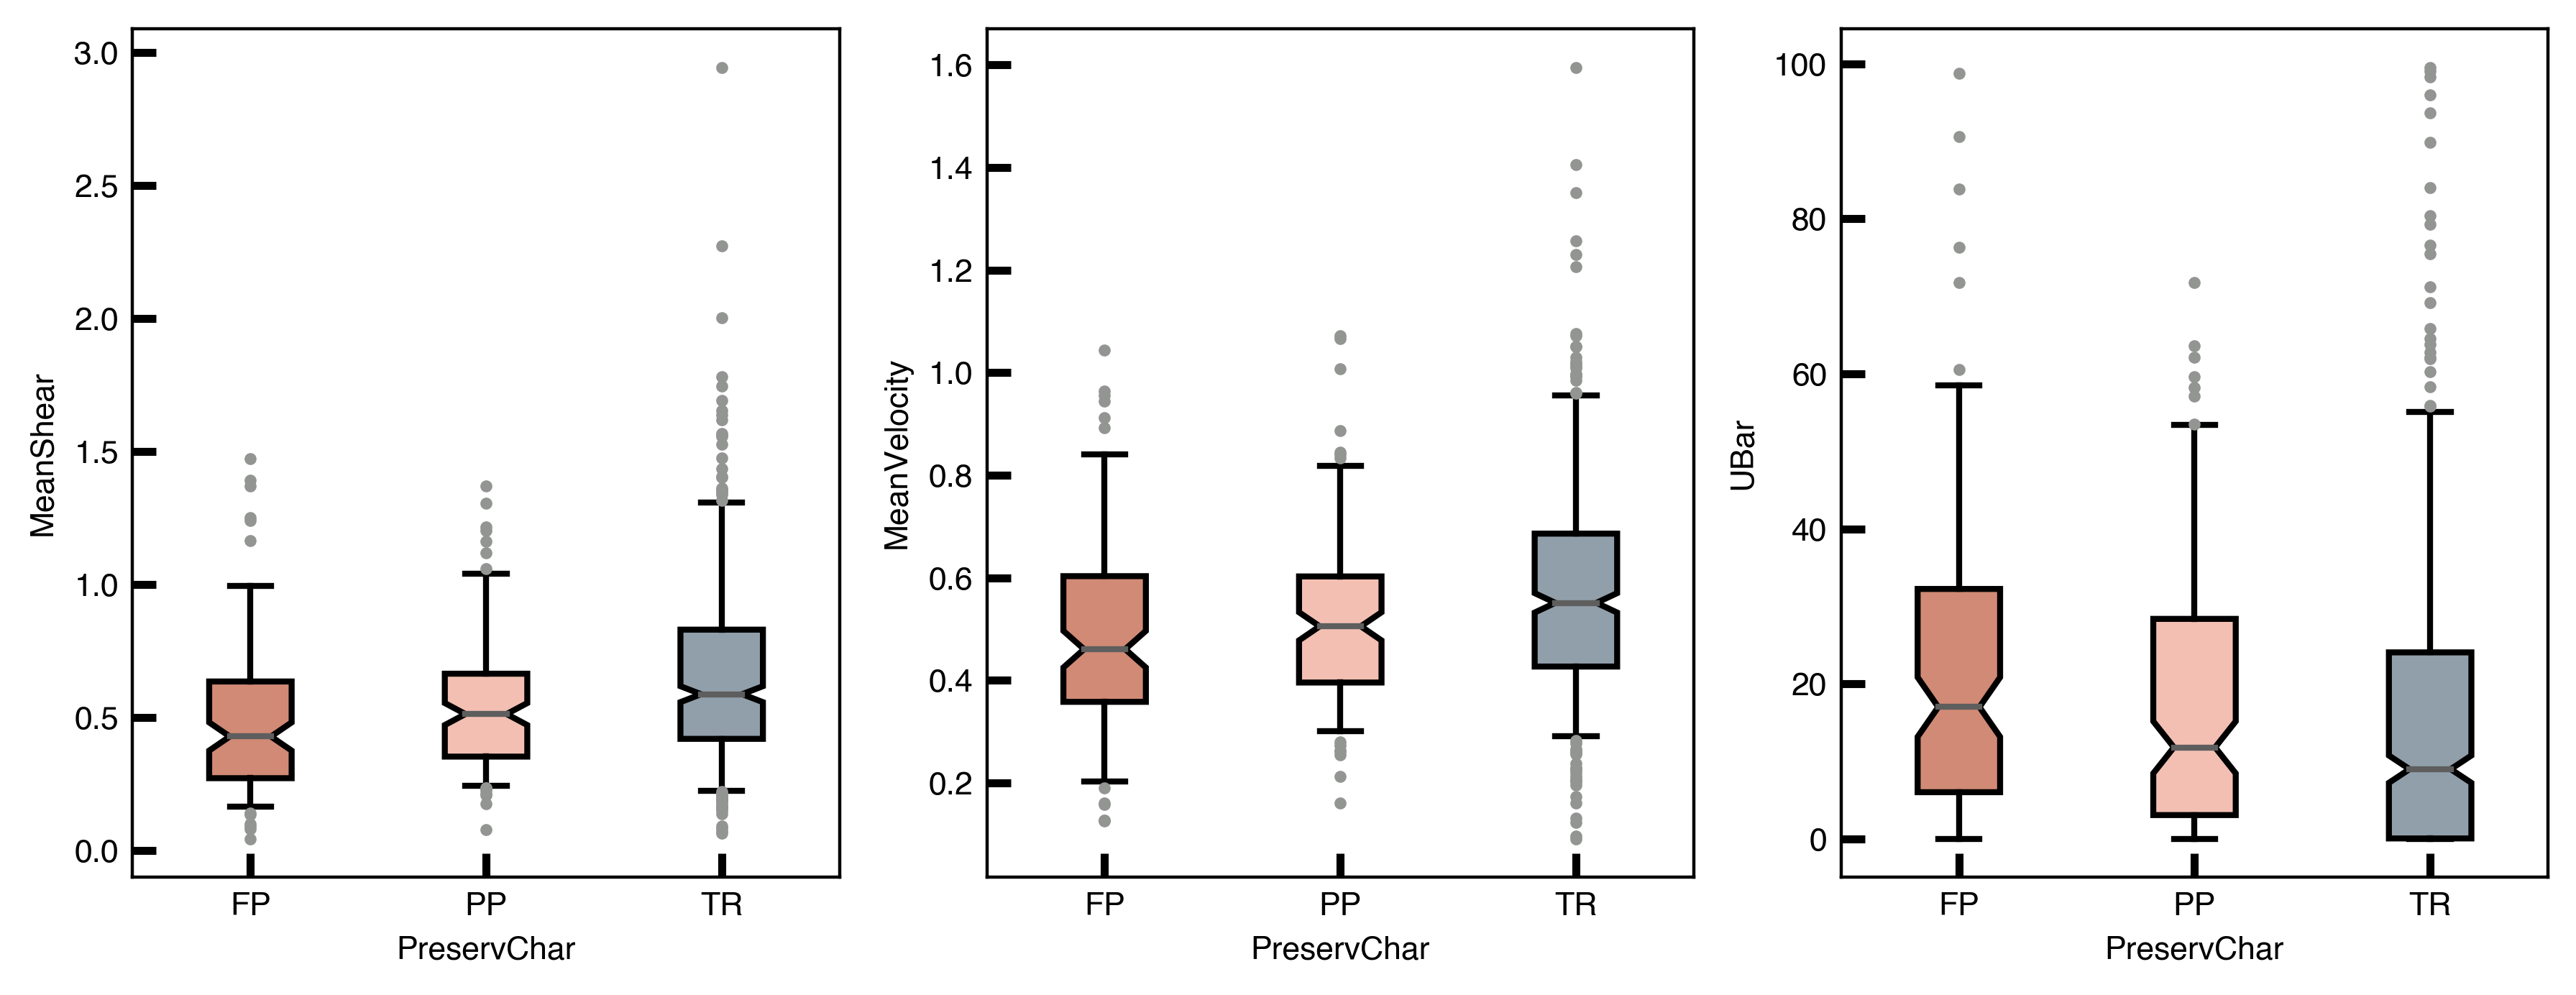

In [15]:
## PANEL 1———————time—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(xs_props), figsize = (len(xs_props)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = xs_props[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
    

# ax.set_alpha(0)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-supplement_bp_xsprops.png', dpi = 300)

fig, ax = plt.subplots(1, len(clino_geom), figsize = (len(clino_geom)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = clino_geom[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-supplement_bp_clino_geom.png', dpi = 300)

fig, ax = plt.subplots(1, len(facies), figsize = (len(facies)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = facies[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)

# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-supplement_bp_facies.png', dpi = 300, transparent = True)

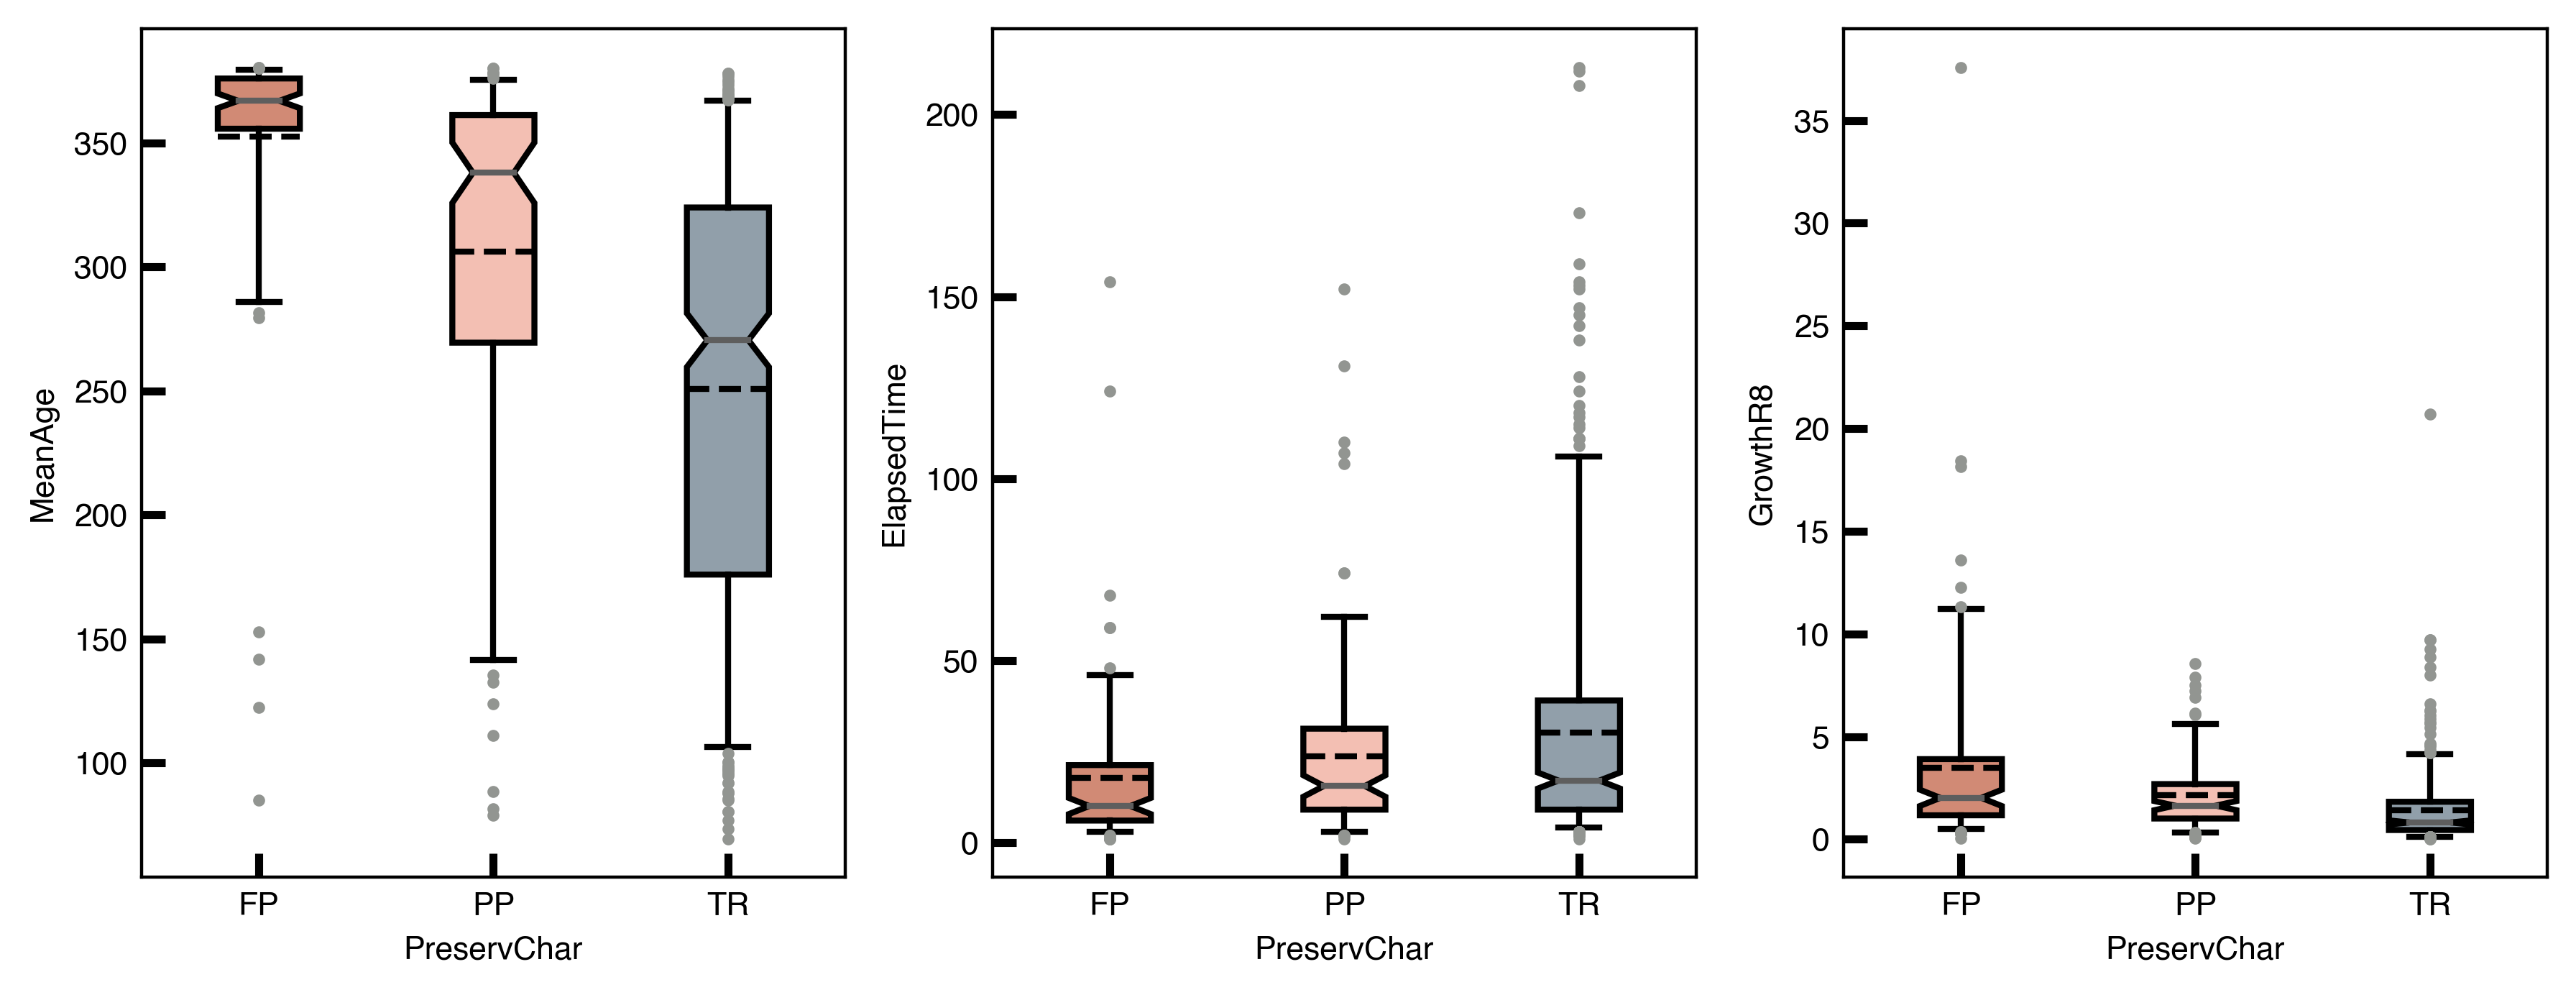

In [16]:
## PANEL 1———————time—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (len(time)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax.tick_params(direction='in', length=6, width=2, colors='r',
#                grid_color='r', grid_alpha=0.5)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = time[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, showmeans = True, meanline=True, meanprops = meanprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-3-3_panel3-time.png', dpi = 300)

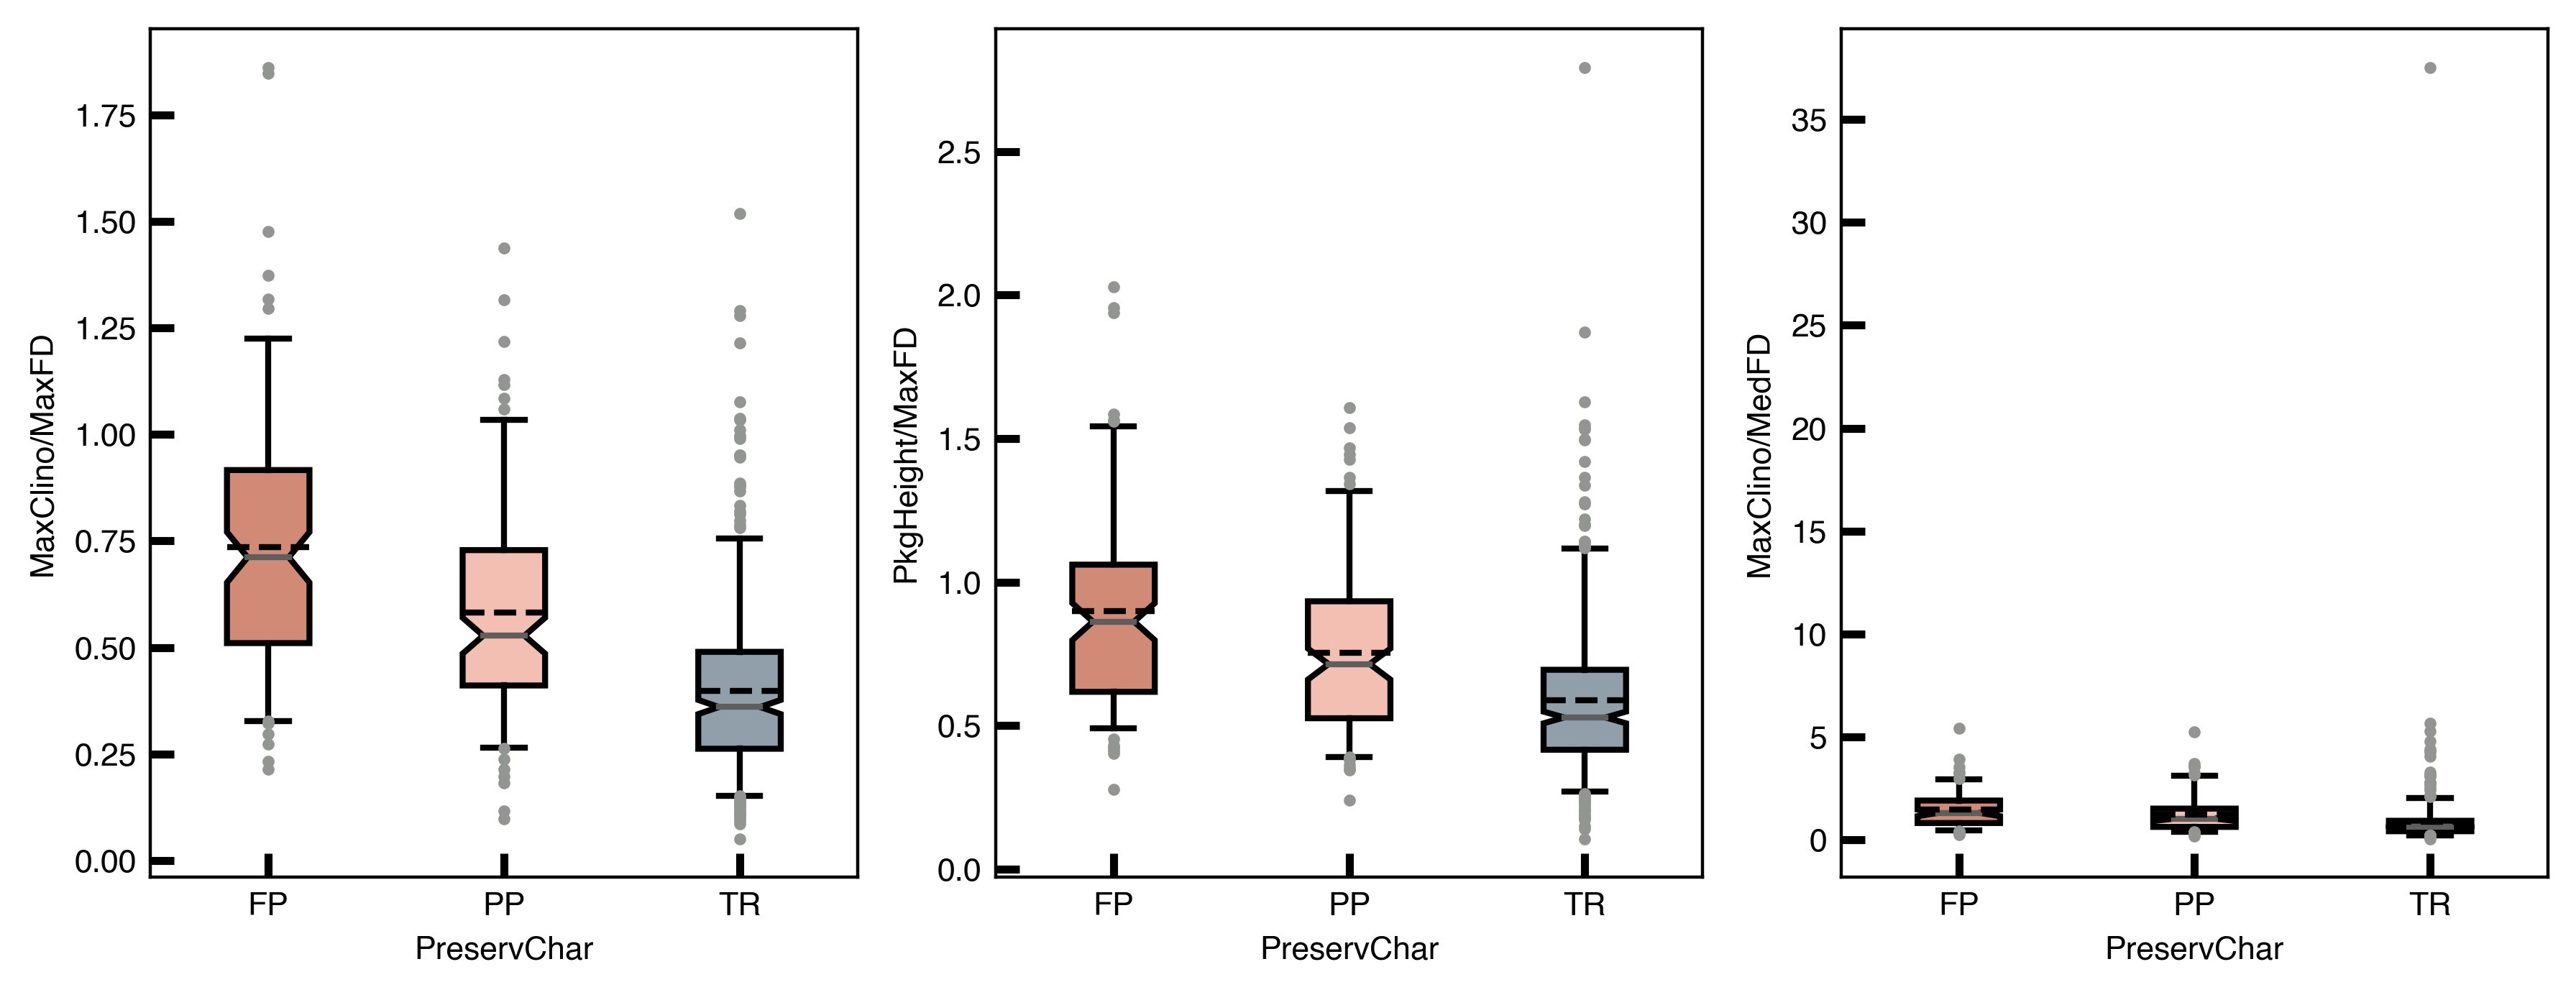

In [17]:
## PANEL 1———————scalers—————————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(time), figsize = (len(time)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax.tick_params(direction='in', length=6, width=2, colors='r',
#                grid_color='r', grid_alpha=0.5)
ax = ax.ravel()

for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = scalers[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, showfliers = True, 
               boxprops = boxprops, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, showmeans = True, meanline=True, meanprops = meanprops)#, bw = 0.5)0
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel1.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-3-3_panel3-scaler.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-3-3_panel3-scaler.eps', format = 'eps')

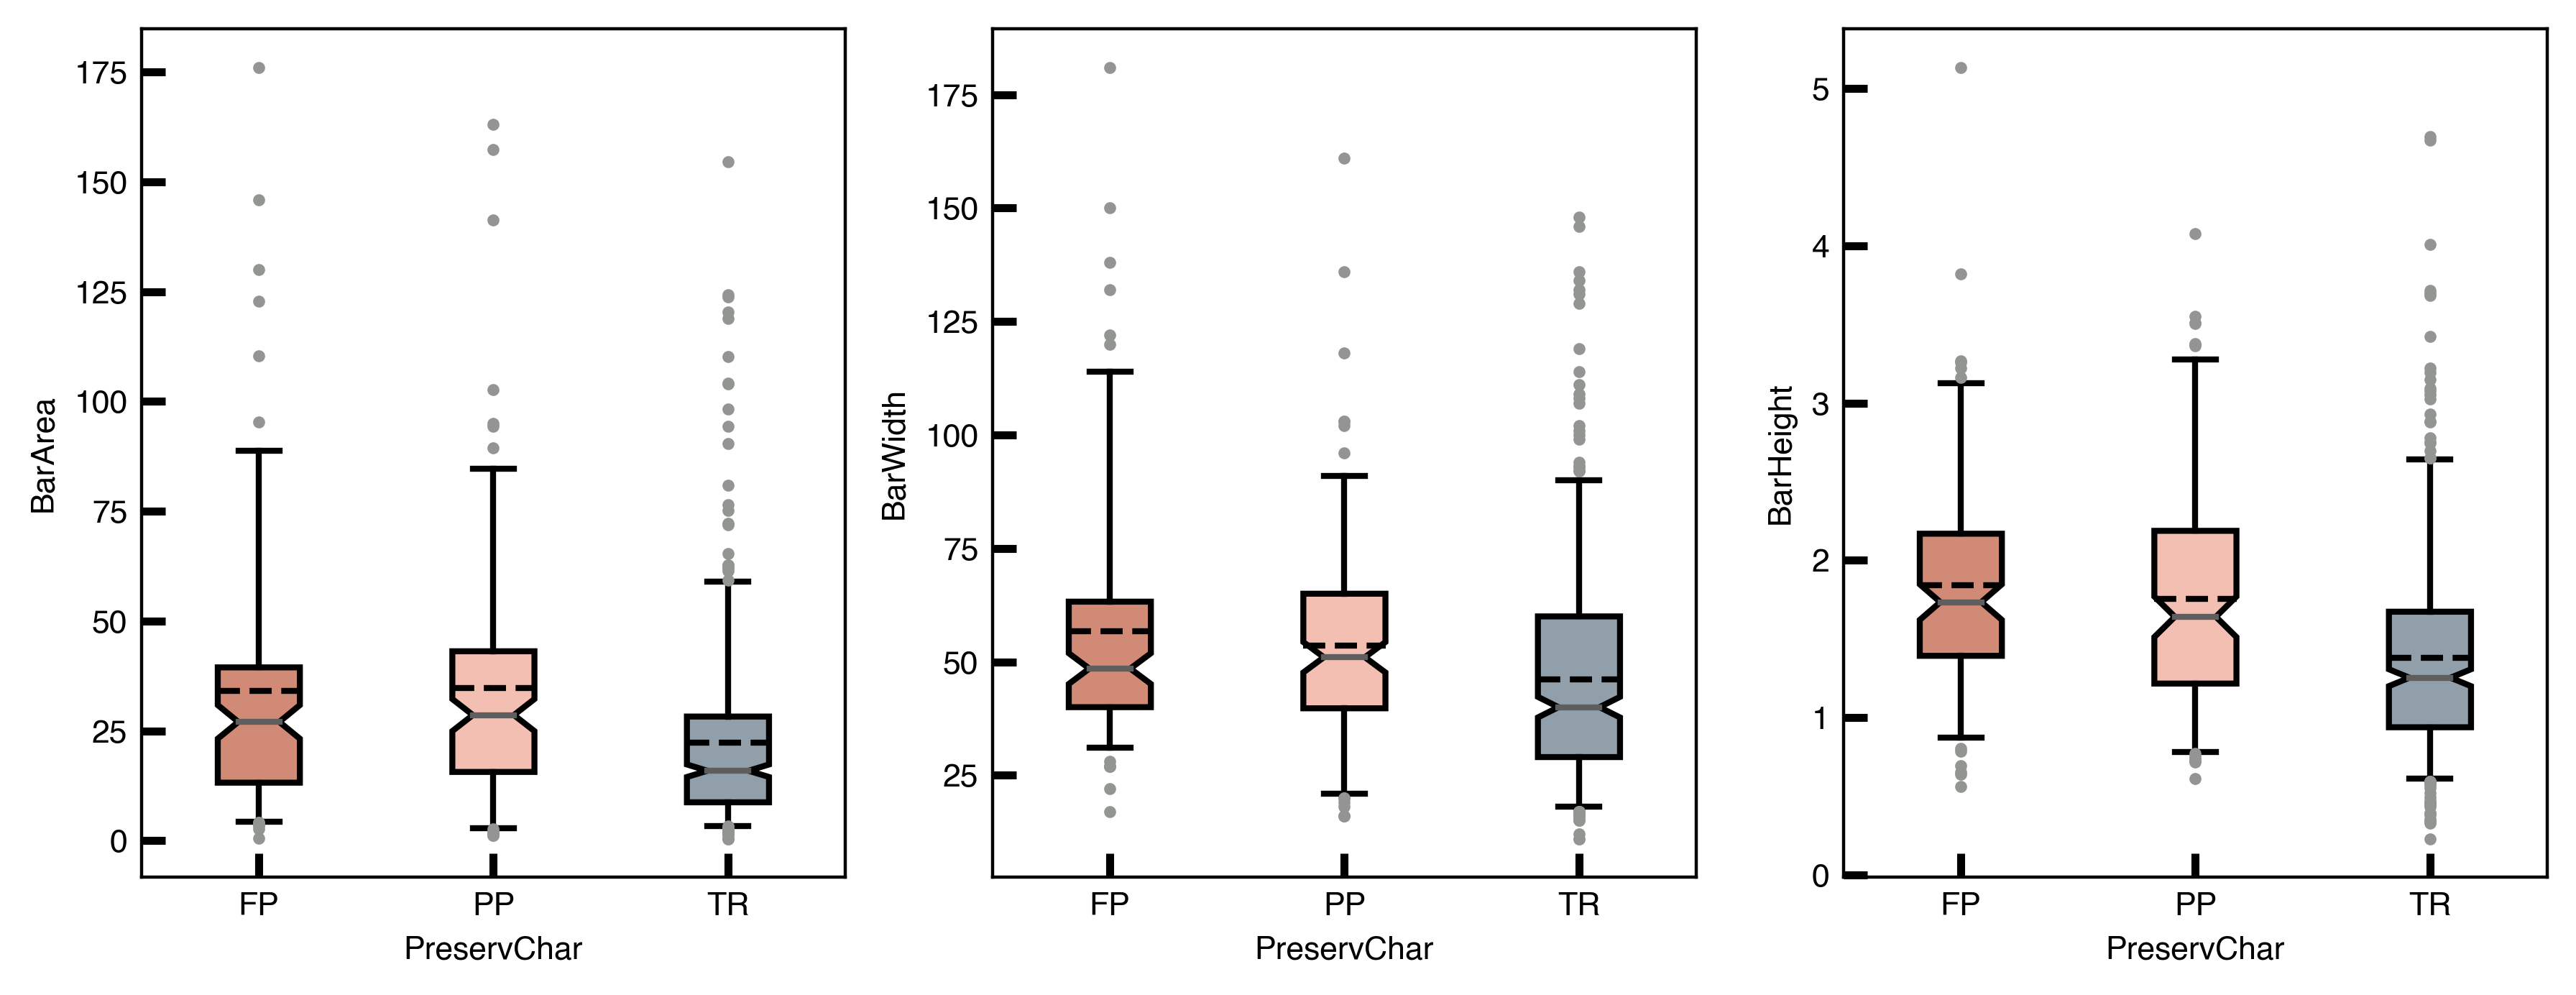

In [18]:
## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, len(geometric_vars), figsize = (len(geometric_vars)*3, 3.5), dpi = 400, tight_layout = True, squeeze = True)
ax = ax.ravel()
for i, a in enumerate(ax):
    bp = sns.boxplot(data = allbars[allbars['StartTime']>eqt], x = 'PreservChar', y = geometric_vars[i], palette = pres_palette, ax = a, linewidth = linewidth, width = boxwidth, notch = True, 
               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops,showmeans = True, meanline=True, meanprops = meanprops)
    
    bp.tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-3-3_panel1-geometry.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/panel3.png', dpi = 400)
# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)

In [15]:
abcrop = allbars[allbars['StartTime']>eqt]

Text(0, 0.5, 'Age')

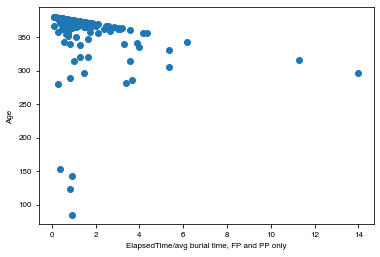

In [16]:
abcroppres = abcrop[np.logical_or(abcrop['PreservChar']=='FP', abcrop['PreservChar']=='FP')]
plt.scatter(abcroppres['ElapsedTime']/11, abcroppres['MeanAge'])
plt.xlabel('ElapsedTime/avg burial time, FP and PP only')
plt.ylabel('Age')

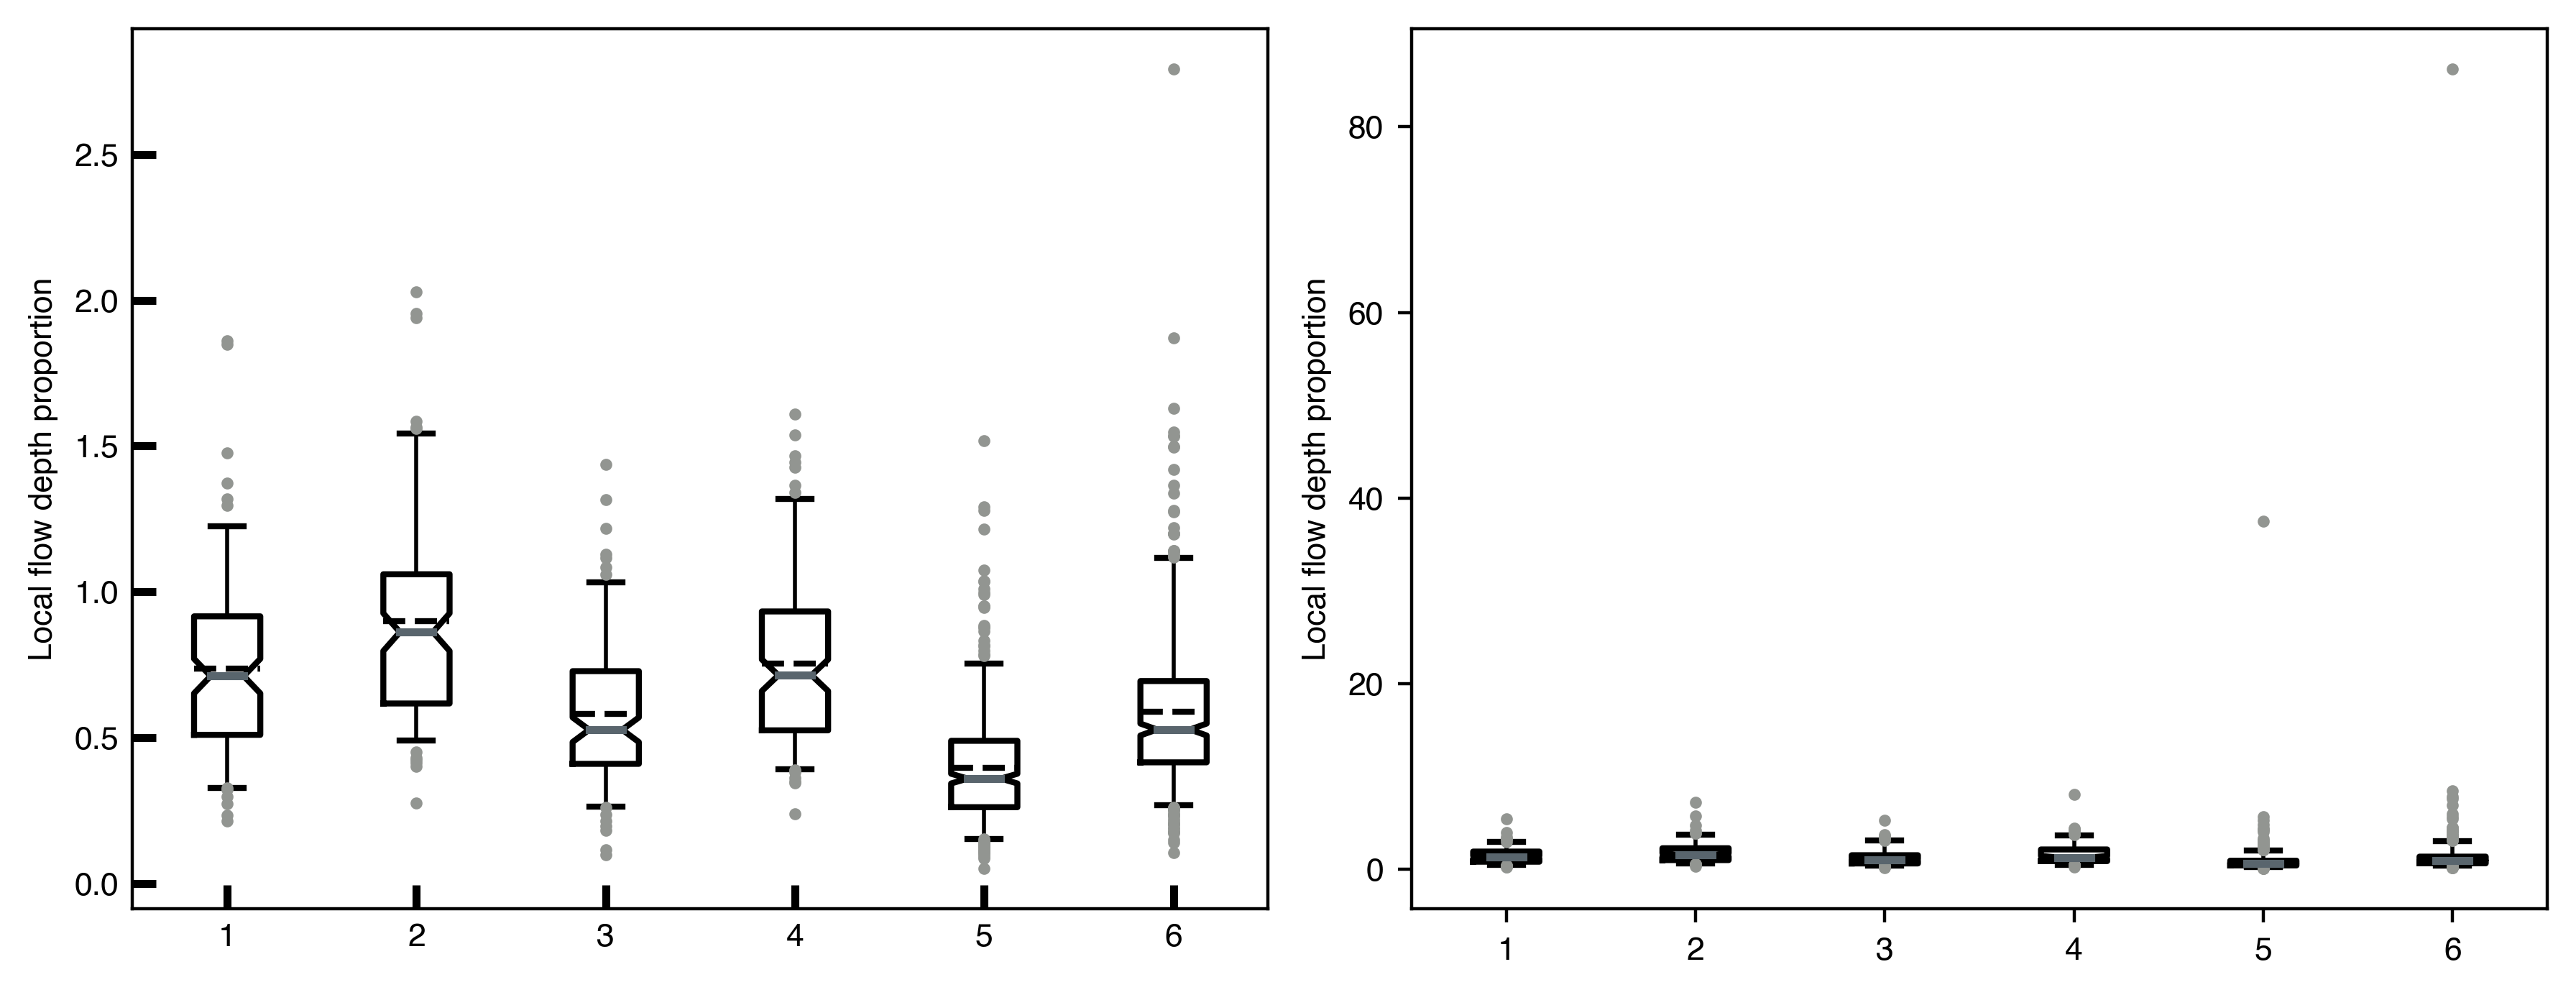

In [21]:
boxprops = {'linewidth': 1.5}#, 'notch_color': 'grey'}
medianprops = {'color': 'xkcd:slate grey', 'linewidth':2}

# ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
#               boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops =

## PANEL 3—————————geometric variables———————————————————————————————————————————————————————————————————————————————————————
fig, ax = plt.subplots(1, 2, figsize = (9, 3.5), dpi = 400, tight_layout = True, squeeze = True)
# ax = ax.ravel()
# scalers = ['MaxClino/MaxFD', 'PkgHeight/MaxFD', 'MaxClino/MedFD', 'PkgHeight/MedFD']
# for idx, pres in enumerate(['FP', 'PP', 'TR']):
ab = ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, showmeans = True, meanline=True, meanprops = meanprops, flierprops = flierprops, medianprops = medianprops,);
ax[0].tick_params(direction='in', length=6, width=2, colors='k',
               grid_color='k', grid_alpha=0.5)
ax[0].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='FP'], positions = [2], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, showmeans = True, meanline=True, meanprops = meanprops,flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='PP'], positions = [3], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, showmeans = True, meanline=True, meanprops = meanprops,flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='PP'], positions = [4], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, showmeans = True, meanline=True, meanprops = meanprops,flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['MaxClino/MaxFD'][abcrop['PreservChar']=='TR'], positions = [5], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, showmeans = True, meanline=True, meanprops = meanprops,flierprops = flierprops, medianprops = medianprops);
ax[0].boxplot(abcrop['PkgHeight/MaxFD'][abcrop['PreservChar']=='TR'], positions = [6], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, showmeans = True, meanline=True, meanprops = meanprops,flierprops = flierprops, medianprops = medianprops);
ax[0].set_ylabel('Local flow depth proportion')



ax[1].set_ylabel('Local flow depth proportion')
ax[1].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='FP'], positions = [1], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='FP'], positions = [2], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='PP'], positions = [3], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='PP'], positions = [4], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['MaxClino/MedFD'][abcrop['PreservChar']=='TR'], positions = [5], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);
ax[1].boxplot(abcrop['PkgHeight/MedFD'][abcrop['PreservChar']=='TR'], positions = [6], widths = boxwidth, notch = True, 
              boxprops = boxprops, showfliers = True, whis=[5, 95], whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops, medianprops = medianprops);

# ax[3].set_ylim(0, 300)
# plt.savefig('/Users/safiya/Desktop/sacnas22_poster/panel3.png', dpi = 400)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/p-6-2_panel4-scaling.png', dpi = 300)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/maxvmed-scaling.png', dpi = 300, transparent = True)


## Compare between sections
### Proportion (skyscraper) plot, make sure sort is FP, PP, TR

In [17]:
## load cumulative props of strat and bed facies from fulldomain processes
bed_bottoms = np.load('/Users/safiya/Desktop/BarManuscript_2022-local/bed_perc.npy', allow_pickle = True)
strat_bottoms = np.load('/Users/safiya/Desktop/BarManuscript_2022-local/strat_perc.npy', allow_pickle = True)

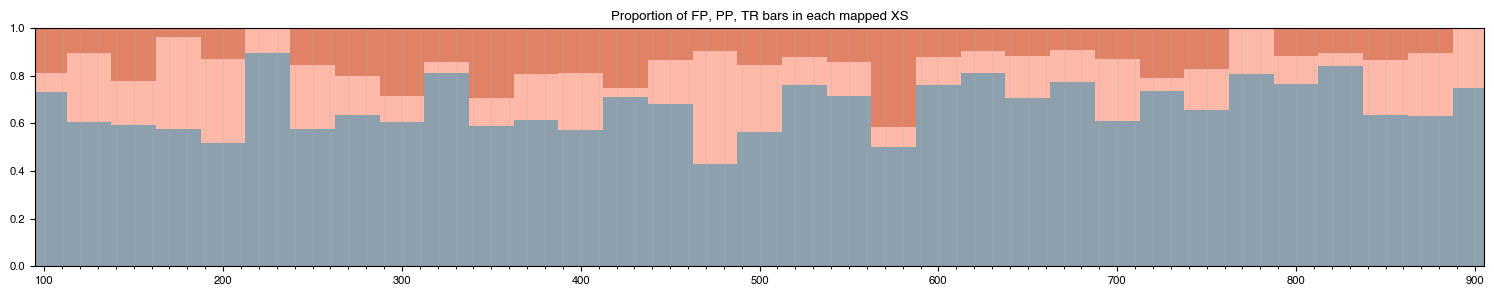

In [18]:
activech_mode = stats.mode(active_channels, axis = 1)[0]
pres_frequencies = np.empty([4, len(np.unique(allbars['iloc']))])
pres_frequencies[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 25

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    totalbars = len(subsample)
    pres_frequencies[1, idx] = len(subsample[subsample['PreservChar']=='FP'])/totalbars
    pres_frequencies[2, idx] = len(subsample[subsample['PreservChar']=='PP'])/totalbars
    pres_frequencies[3, idx] = len(subsample[subsample['PreservChar']=='TR'])/totalbars

    plt.bar(i, pres_frequencies[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_frequencies[2, idx], w, bottom = pres_frequencies[3, idx], color = pres_cols[1])
    plt.bar(i, pres_frequencies[1, idx], w, bottom = np.sum(pres_frequencies[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.25)

# ax1.fill_between(np.arange(0, len(active_channels)), active_channels.min(axis = 1), active_channels.max(axis = 1), alpha = 0.1, color = 'k')
# plt.plot(activech_mode, 'k-')
# # plt.fill_between(np.arange(0, len(total_wr_2h))*10, total_wr_2h.min(axis = 1), total_wr_2h.max(axis = 1), alpha = 0.1, color = 'k')

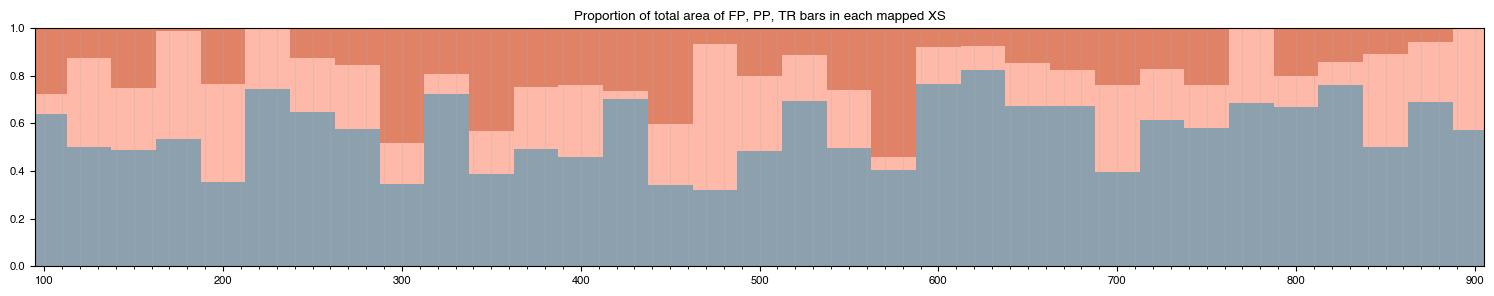

In [19]:
pres_area = np.empty([4, len(np.unique(allbars['iloc']))])
pres_area[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 25

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    chanarea = subsample['Section Area'].iloc[0]
    propmapped = sum(subsample['ChannelProp'])
#     pres_area[1, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='FP'])/chanarea
#     pres_area[2, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='PP'])/chanarea
#     pres_area[3, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='TR'])/chanarea
    
    ## Using only channel proportion
    pres_area[1, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='FP'])/propmapped
    pres_area[2, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='PP'])/propmapped
    pres_area[3, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='TR'])/propmapped

    plt.bar(i, pres_area[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_area[2, idx], w, bottom = pres_area[3, idx], color = pres_cols[1])
    plt.bar(i, pres_area[1, idx], w, bottom = np.sum(pres_area[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of total area of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

ax.grid(axis = 'x', which = 'both', alpha = 0.25)
# ax.plot(np.arange(100, 925, 25), bed_bottoms[1, :], 'k--')
# ax.plot(np.arange(100, 925, 25), strat_bottoms[1, :], 'k-')
# ax1 = ax.twinx()
# ax.plot(avg_wr, 'k-', label = 'WR per hr')
# ax.plot(np.nanmean(widening_tt, axis = 1), 'k--', label = 'TT scaled')
# ax.axhline(np.quantile(avg_wr, 0.5), c = 'k', ls = '--', alpha = 0.5)
# ax.set_ylabel('Average widening rate, per hour')
# ax1.plot(np.arange(100, 925, 25), stats.variation(threaddf_mapped.iloc[:, 2:35], axis = 0), label = 'active CV')
# ax1.plot(np.arange(100, 925, 25), stats.variation(wetwidthdf_mapped.iloc[:, 2:35], axis = 0), label = 'wet width CV')
# ax.plot(np.arange(100, 925, 25), stats.variation(np.divide(wetwidthdf_mapped.iloc[:, 2:35], threaddf_mapped.iloc[:, 2:35]), axis = 0), label = 'WW/active CV', c = 'r')
# ax.legend()

# ax1.plot(np.arange(100, 925, 25), np.nanmean(np.divide(wetwidthdf_mapped.iloc[:, 2:35], threaddf_mapped.iloc[:, 2:35]), axis = 0), label = 'WW/active CV', c = 'b', ls = '--')

# plt.savefig('/Users/safiya/Desktop/AGU2022/pythonfigs_4poster/skyscraper250m-area.png', transparent = True, dpi = 300)
# plt.savefig('/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/skuscrapers-patch2-final.png', dpi = 300)

In [20]:
# pres_area, these are the proportion of the area:
#     row 0 = iloc, row 1 = FP, row 2 = PP, row 3 = TR 
# columns = sections

global_trunc = np.nanmean(pres_area[3, :]) ## mean global truncated proportion 
print(f'Global mean truncated deposit area = {np.round(global_trunc, 2)}')

Global mean truncated deposit area = 0.57


In [154]:
bootstrap_plot = pd.DataFrame(columns = ['nsec=1', 'nsec=2', 'nsec=3', 'nsec=4', 'nsec=5', 'nsec=7', 'nsec=10'])
def bootstrap(data, nsections, msamples):
    '''function to pull preservation statistics (data) from n sections, m amount of samples, 
    data is the array of pres_area, or pres_count or maybe strat_area or bed_area (the input to the skyscraper plots)
    something formatted with the first row being the ilocs, 
    and the subsequent rows being iloc data by preservation gradient or something
    
    nsections = number of sections being samples
    msamples = number of times you'll pull the sample'''
    sec_idx = np.arange(data.shape[1]) ##get indicies of rows
    data_arr = np.empty([msamples, nsections]) ## store all the trunc stats for each sampling draw?
    for samp in range(msamples):
#         print(samp, data_arr.shape)
        data_arr[samp, :] = pres_area[3, :][np.random.choice(sec_idx, size = nsections, replace = False)]
    
    return(data_arr)

In [196]:
msamp = 50
# boot1 = np.mean(bootstrap(pres_area, 1, msamp), axis = 1)
boot1 = deepcopy(pres_area[3, :])
boot2 = np.nanmean(bootstrap(pres_area, 2, msamp), axis = 1)
boot3 = np.nanmean(bootstrap(pres_area, 3, msamp), axis = 1)
boot4 = np.nanmean(bootstrap(pres_area, 4, msamp), axis = 1)
boot5 = np.nanmean(bootstrap(pres_area, 5, msamp), axis = 1)
boot7 = np.nanmean(bootstrap(pres_area, 7, msamp), axis = 1)
boot10 = np.nanmean(bootstrap(pres_area, 10, msamp), axis = 1)
boot13 = np.nanmean(bootstrap(pres_area, 13, msamp), axis = 1)
boot9 = np.nanmean(bootstrap(pres_area, 9, msamp), axis = 1)
boot6 = np.nanmean(bootstrap(pres_area, 6, msamp), axis = 1)
boot8 = np.nanmean(bootstrap(pres_area, 8, msamp), axis = 1)

boots = [boot1, boot2, boot3, boot4, boot5, boot7, boot10, boot13, boot9, boot6, boot8]
bootnames = ['boot1', 'boot2', 'boot3', 'boot4', 'boot5', 'boot7', 'boot8', 'boot10', 'boot13', 'boot9', 'boot6']
# boot_names = ['1 sam', '2 sam', '3 sam', '4 sam', '5 sam', '7 sam', '10 sam']

In [197]:
boxprops = {'linewidth': 1.5}#, 'notch_color': 'grey'}
medianprops = {'color': 'xkcd:slate grey', 'linewidth':1}
meanprops = dict(marker = 'o', markerfacecolor = 'blue', ms = 5, mec = 'k', mew = 0, linestyle = '--', linewidth = 2, color = 'k')

In [198]:
bootarr = np.empty([50, 11])
bootarr[:] = np.nan
bootarr[:33, 0] = boot1
bootarr[:, 1] = boot2
bootarr[:, 2] = boot3
bootarr[:, 3] = boot4
bootarr[:, 4] = boot5
bootarr[:, 5] = boot7
bootarr[:, 6] = boot8
bootarr[:, 7] = boot10
bootarr[:, 8] = boot13
bootarr[:, 9] = boot9
bootarr[:, 10] = boot6

bootdf = pd.DataFrame(bootarr, columns = bootnames)

In [199]:
meanboot = np.nanmean(bootarr, axis = 0)
err = .05*meanboot

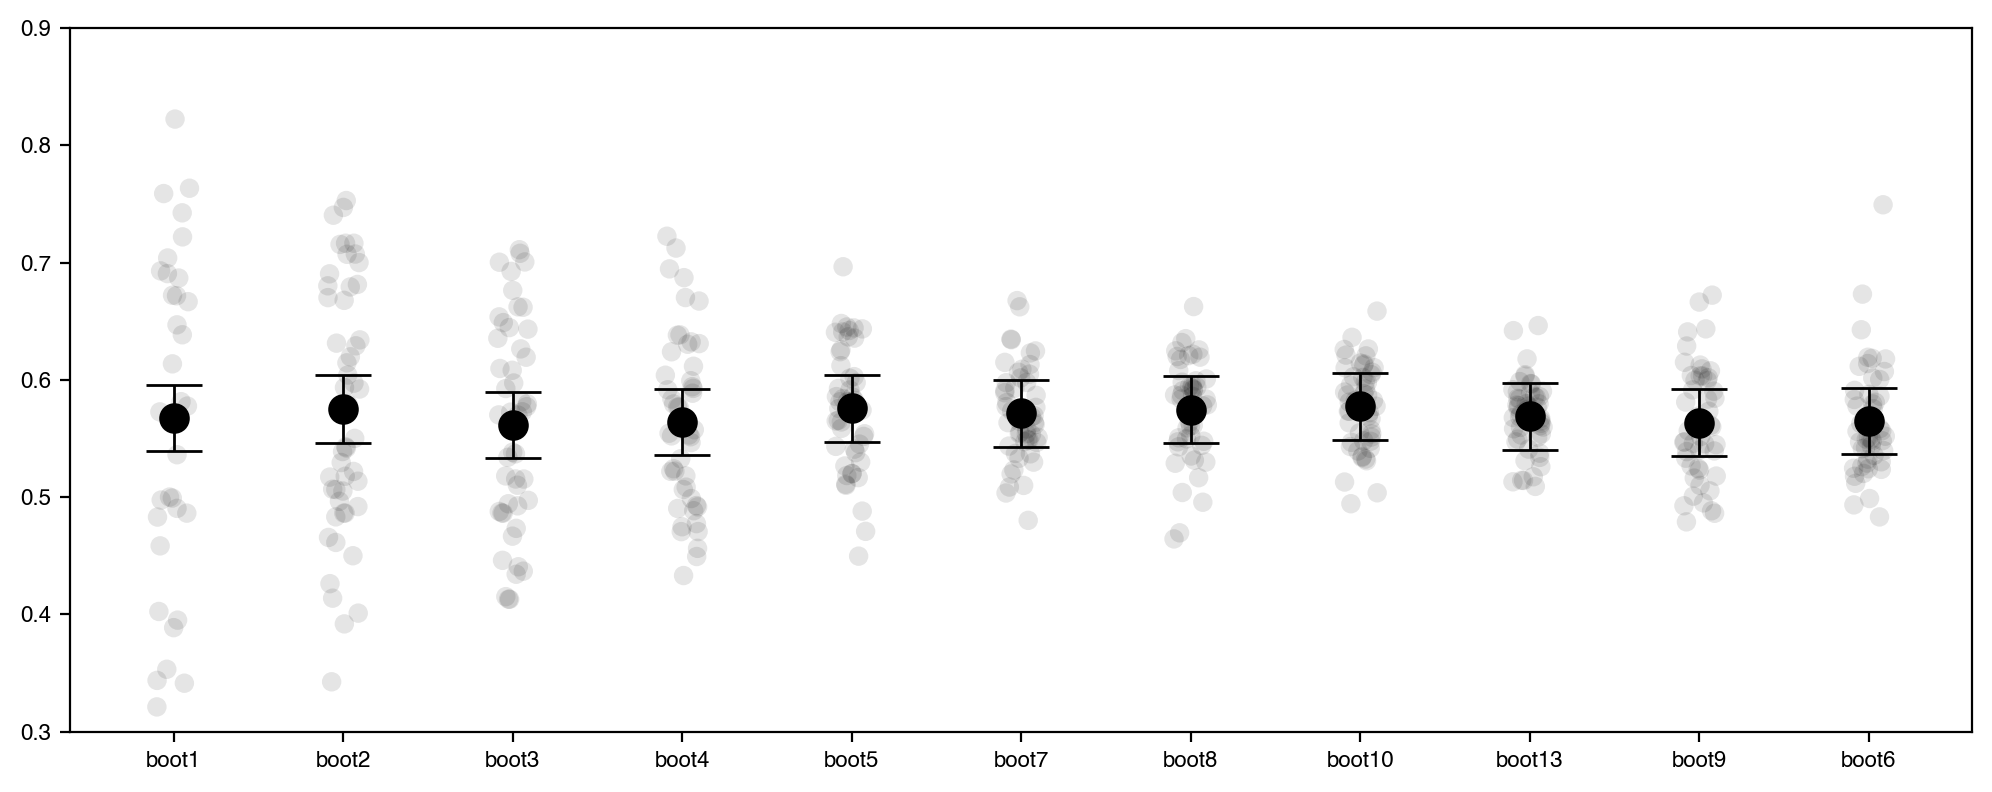

In [200]:
plt.figure(figsize = (10, 4), tight_layout = True, dpi = 200)
plt.ylim(.3, .9)
sns.stripplot(data = bootdf, color = 'k', alpha = 0.1, size = 7)
plt.errorbar(np.arange(0, 11), meanboot, yerr = err, ecolor = 'k', elinewidth = 1, capsize = 10, lw = 0, ms = 10, marker = 'o', mfc = 'k', mec = 'k')
plt.savefig(f'/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/bootstrap_swa6rm_{msamp}.svg', dpi = 300, transparent = True)

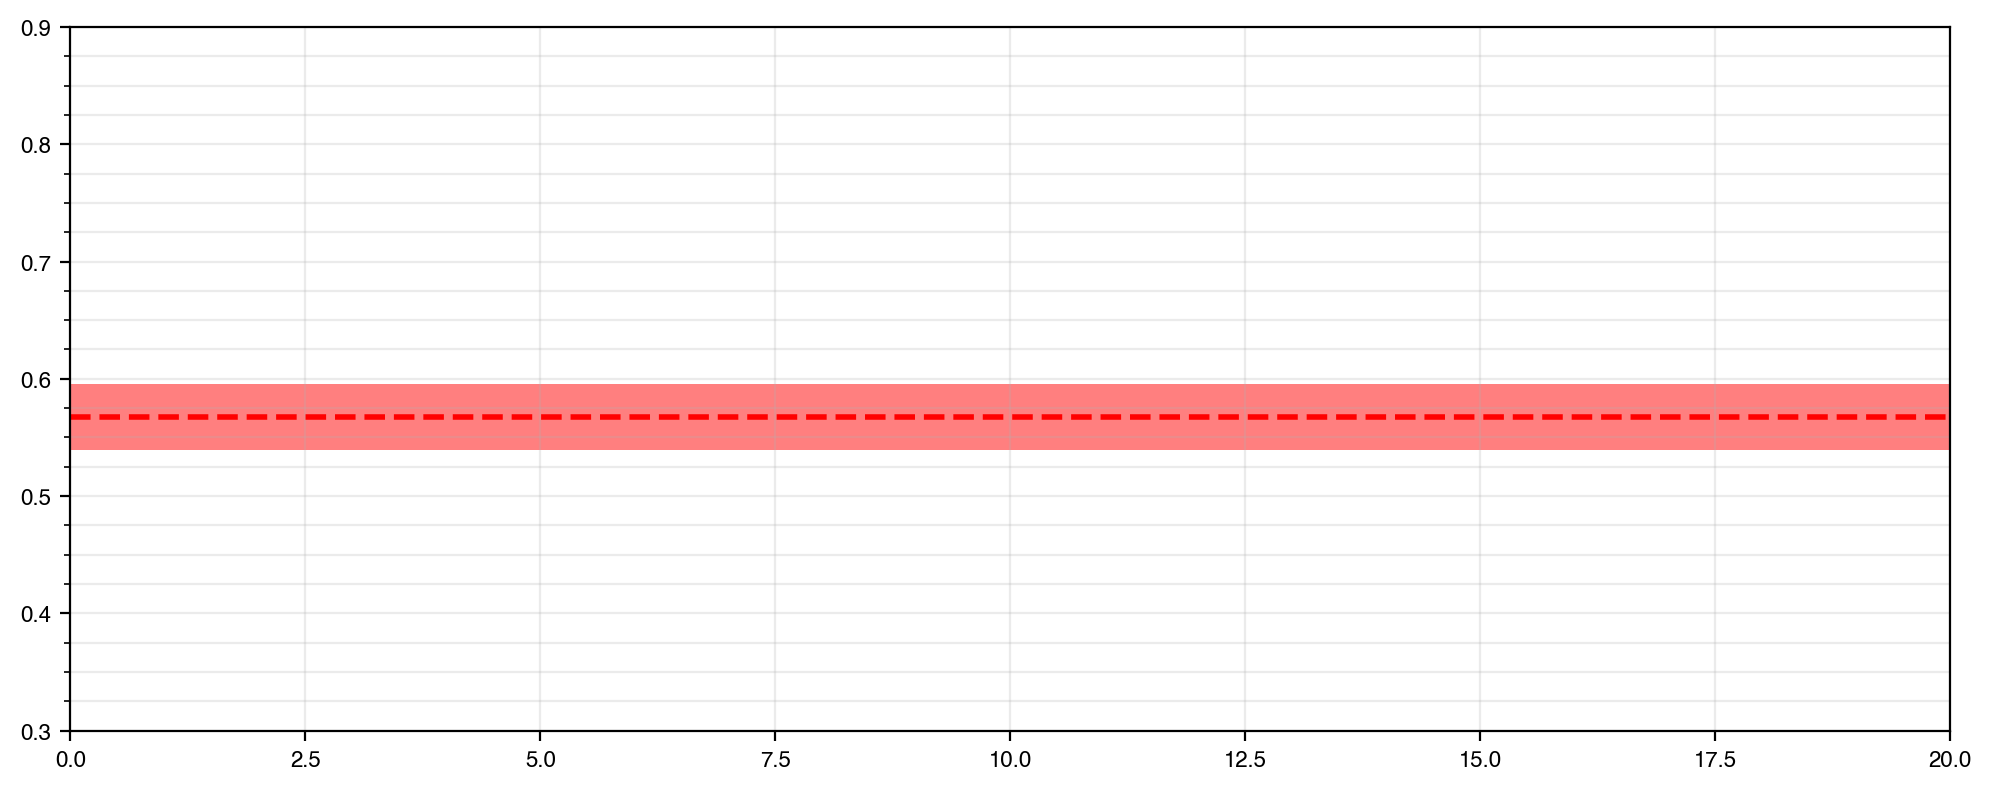

In [188]:
plt.figure(figsize = (10, 4), tight_layout = True, dpi = 200)
plt.axhline(global_trunc, c = 'r', ls = '--', lw = 2)
plt.xlim(0, 20)
plt.ylim(.3, .9)
plt.fill_between([0, 20], global_trunc*0.95, global_trunc*1.05, color = 'r', alpha = .5, lw = 0)
ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(.025))
ax.yaxis.set_major_locator(MultipleLocator(.1))

ax.grid(axis = 'y', which = 'both', alpha = 0.25)
ax.grid(axis = 'x', which = 'major', alpha = 0.25)

# plt.savefig(f'/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/bootstrap_axes_{msamp}.png', dpi = 300, transparent = True)

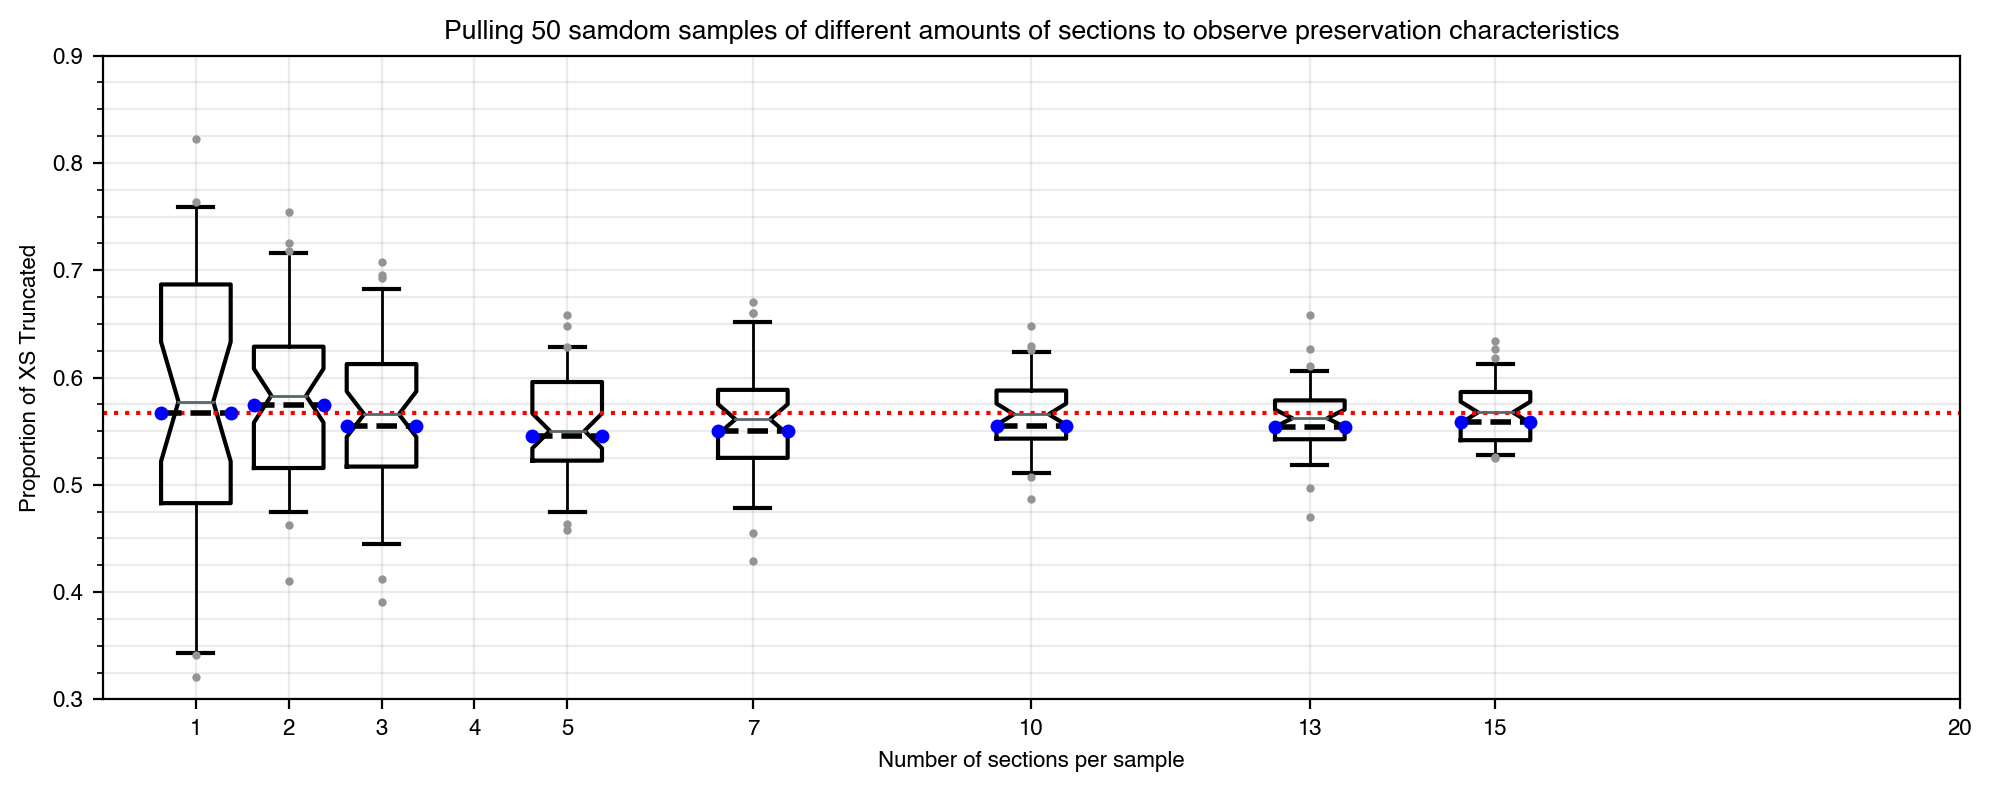

In [27]:
plt.figure(figsize = (10, 4), tight_layout = True, dpi = 200)
# meanline
plt.boxplot(boots, positions = [1, 2, 3, 4, 5, 7, 10, 13, 15, 20, 27], meanline = True, notch = True, bootstrap = None, whis = [5, 95], boxprops = boxprops,
           medianprops = medianprops, meanprops = meanprops, showmeans = True, widths = .75, showfliers = True, 
            whiskerprops = whiskerprops, capprops = capprops, flierprops = flierprops)

plt.title(f'Pulling {msamp} samdom samples of different amounts of sections to observe preservation characteristics')
plt.ylabel('Proportion of XS Truncated')
plt.xlabel('Number of sections per sample')
plt.axhline(global_trunc, c = 'r', ls = ':')
plt.xlim(0, 20)
plt.ylim(.3, .9)
ax = plt.gca()
ax.yaxis.set_minor_locator(MultipleLocator(.025))
ax.yaxis.set_major_locator(MultipleLocator(.1))

ax.grid(axis = 'y', which = 'both', alpha = 0.25)
ax.grid(axis = 'x', which = 'major', alpha = 0.25)


# plt.savefig(f'/Users/safiya/Desktop/BarManuscript_2022-local/figs/python-results/bootstrap_2mas_{msamp}.png', dpi = 300)

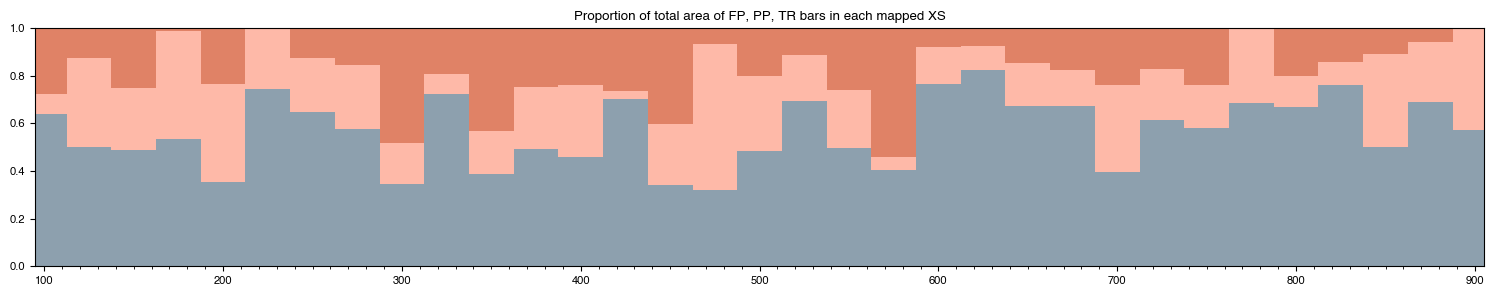

In [30]:
pres_area = np.empty([4, len(np.unique(allbars['iloc']))])
pres_area[0, :] = np.unique(allbars['iloc'])*10

fig = plt.figure(figsize = (15, 3), tight_layout = True, dpi =100)
w = 25

for idx, i in enumerate(np.unique(allbars['iloc'])):
    subsample = allbars[allbars['iloc']==i]
    chanarea = subsample['Section Area'].iloc[0]
    propmapped = sum(subsample['ChannelProp'])
#     pres_area[1, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='FP'])/chanarea
#     pres_area[2, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='PP'])/chanarea
#     pres_area[3, idx] = np.sum(subsample['BarArea'][subsample['PreservChar']=='TR'])/chanarea
    
    ## Using only channel proportion
    pres_area[1, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='FP'])/propmapped
    pres_area[2, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='PP'])/propmapped
    pres_area[3, idx] = np.sum(subsample['ChannelProp'][subsample['PreservChar']=='TR'])/propmapped

    plt.bar(i, pres_area[3, idx], w, color = pres_cols[2])
    plt.bar(i, pres_area[2, idx], w, bottom = pres_area[3, idx], color = pres_cols[1])
    plt.bar(i, pres_area[1, idx], w, bottom = np.sum(pres_area[2:, idx], axis = 0), color = pres_cols[0])
plt.title('Proportion of total area of FP, PP, TR bars in each mapped XS')    
plt.xlim(95, 905)
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(100))

Text(0.5, 1.0, 'Relationship between Preservation area and count of bar packages mapped')

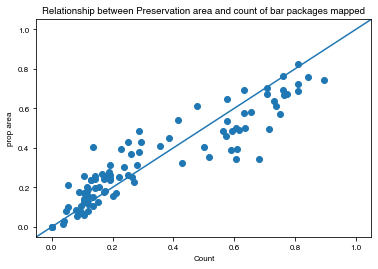

In [31]:
plt.scatter(pres_frequencies[1:, :], pres_area[1:, :])
plt.xlabel('Count')
plt.ylabel('prop area')
plt.axline((0.0, 0.0), (1.0, 1.0))
plt.title('Relationship between Preservation area and count of bar packages mapped')